In [1]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# Read in data
words = open('names.txt', 'r').read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(set(''.join(words)))
c_to_i = {c: i+1 for i, c in enumerate(chars)}
c_to_i['.'] = 0
i_to_c = {i: c for c, i in c_to_i.items()}
vocab_size = len(i_to_c)

In [4]:
# Number of inputs prior to target character
BLOCK_SIZE = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * BLOCK_SIZE

        for ch in w + '.':
            target_idx = c_to_i[ch]
            X.append(context)
            Y.append(target_idx)

            # Slide context window over to next set of chars
            context = context[1:] + [target_idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [90]:
# Instantitate generator
g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        # Set training flag
        self.training = True

        # Initialize training parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Initialize buffers
        self.mean = torch.zeros(dim)
        self.var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.mean
            xvar = self.var
        
        x_hat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * x_hat + self.beta

        # Update buffers
        if self.training:
            with torch.no_grad():
                self.mean = (1 - self.momentum) * self.mean + self.momentum * xmean
                self.var = (1 - self.momentum) * self.var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


# Set hyper parameters
EMBEDDING_DIM = 10
INPUT_DIM = BLOCK_SIZE * EMBEDDING_DIM
HIDDEN_DIM = 100

# Create embedding matrix
C = torch.randn((vocab_size, EMBEDDING_DIM), generator=g)
layers = [
    Linear(INPUT_DIM, HIDDEN_DIM), BatchNorm1d(HIDDEN_DIM), Tanh(),
    Linear(HIDDEN_DIM, HIDDEN_DIM), BatchNorm1d(HIDDEN_DIM), Tanh(),
    Linear(HIDDEN_DIM, HIDDEN_DIM), BatchNorm1d(HIDDEN_DIM), Tanh(),
    Linear(HIDDEN_DIM, HIDDEN_DIM), BatchNorm1d(HIDDEN_DIM), Tanh(),
    Linear(HIDDEN_DIM, HIDDEN_DIM), BatchNorm1d(HIDDEN_DIM), Tanh(),
    Linear(HIDDEN_DIM, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # Normalize last layer
    layers[-1].gamma *= 0.1
    # Apply gain in other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5 / 3)
    
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


47551


In [91]:
losses = []

In [92]:
# Training loop
n_iter = 200000
batch_size = 32
update_to_data = []

for i in range(n_iter):
    # minibatching
    ixs = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    x_batch, y_batch = X_train[ixs], Y_train[ixs]

    # Forward pass
    emb = C[x_batch]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)

    # Compute loss
    loss = F.cross_entropy(x, y_batch)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i <= 1000:
        with torch.no_grad():
            update_to_data.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i % 10000 == 0 or i == n_iter - 1:
        print(f'{i:7d}/{n_iter - 1:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())

      0/ 199999: 3.2870
  10000/ 199999: 2.3578
  20000/ 199999: 2.1043
  30000/ 199999: 1.9646
  40000/ 199999: 2.2144
  50000/ 199999: 2.2267
  60000/ 199999: 1.7339
  70000/ 199999: 2.1750
  80000/ 199999: 2.1895
  90000/ 199999: 1.8280
 100000/ 199999: 2.3632
 110000/ 199999: 2.2012
 120000/ 199999: 2.1030
 130000/ 199999: 1.8564
 140000/ 199999: 1.8051
 150000/ 199999: 1.9257
 160000/ 199999: 1.8764
 170000/ 199999: 1.8336
 180000/ 199999: 2.2312
 190000/ 199999: 2.0511
 199999/ 199999: 2.0511


layer 2 (Tanh): mean -0.00, std 0.63, saturated 2.97%
layer 5 (Tanh): mean +0.01, std 0.64, saturated 2.41%
layer 8 (Tanh): mean -0.00, std 0.64, saturated 2.44%
layer 11 (Tanh): mean +0.00, std 0.64, saturated 2.22%
layer 14 (Tanh): mean -0.00, std 0.64, saturated 2.25%


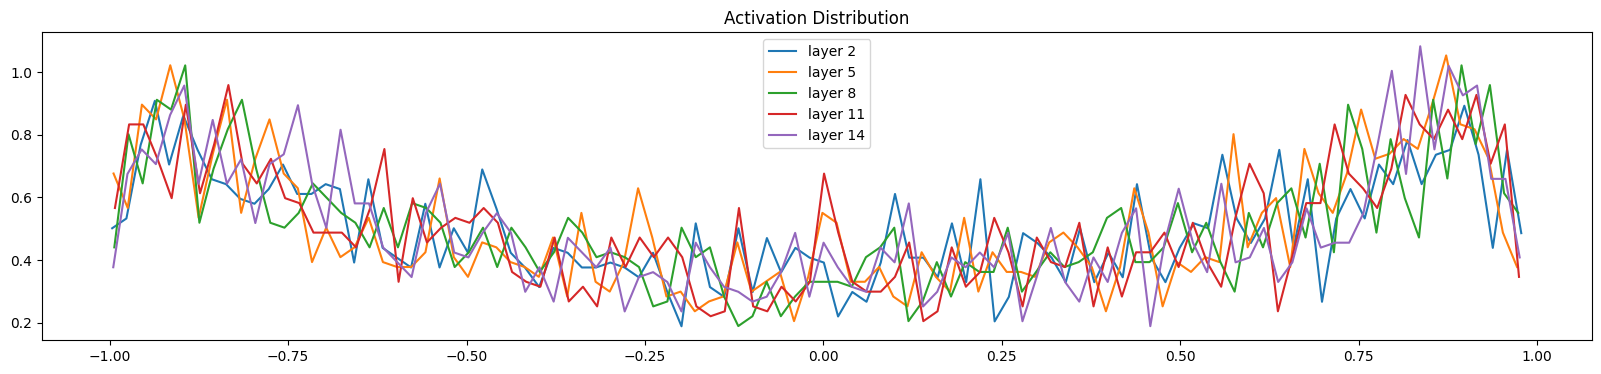

In [82]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} ({layer.__class__.__name__}): mean {t.mean():+.2f}, std {t.std():.2f}, saturated {(t.abs() > 0.97).float().mean() * 100:.2f}%")
        # Compute histogram
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i}')
plt.legend(legends)
plt.title('Activation Distribution');

layer 2 (Tanh): mean +0.000000, std 0.003562
layer 5 (Tanh): mean -0.000000, std 0.003120
layer 8 (Tanh): mean -0.000000, std 0.002904
layer 11 (Tanh): mean -0.000000, std 0.002580
layer 14 (Tanh): mean -0.000000, std 0.002441


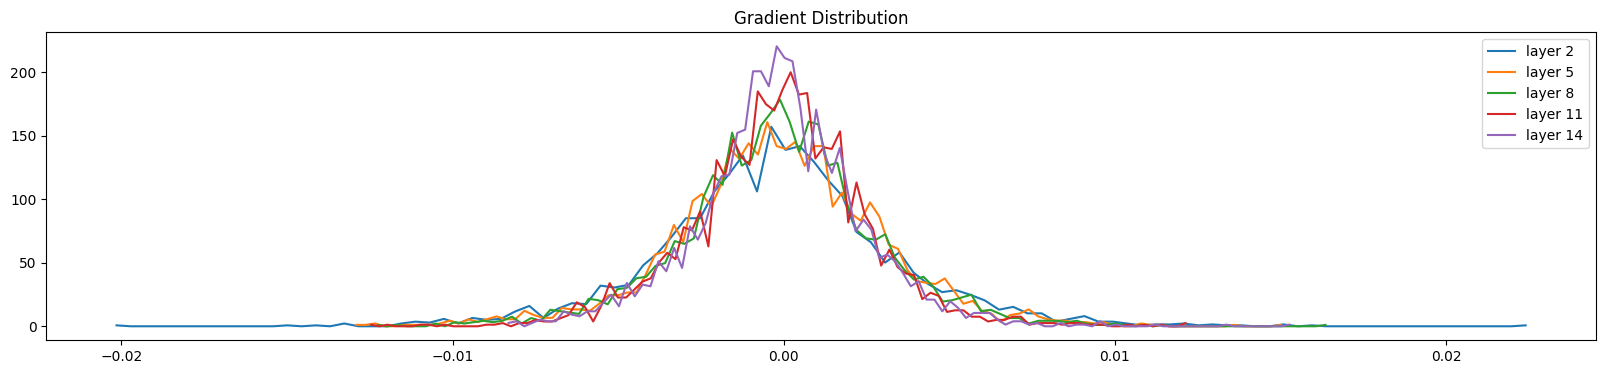

In [83]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} ({layer.__class__.__name__}): mean {t.mean():+.6f}, std {t.std():.6f}")
        # Compute histogram
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i}')
plt.legend(legends)
plt.title('Gradient Distribution');

layer  0: weight     (27, 10) | mean -0.000000 | std 0.008199 | grad:data 0.008190
layer  1: weight    (30, 100) | mean -0.000195 | std 0.007650 | grad:data 0.024477
layer  5: weight   (100, 100) | mean -0.000097 | std 0.006208 | grad:data 0.037129
layer  9: weight   (100, 100) | mean +0.000015 | std 0.005562 | grad:data 0.032976
layer 13: weight   (100, 100) | mean +0.000008 | std 0.005221 | grad:data 0.031101
layer 17: weight   (100, 100) | mean +0.000029 | std 0.004829 | grad:data 0.028764
layer 21: weight    (100, 27) | mean -0.000014 | std 0.009281 | grad:data 0.055688


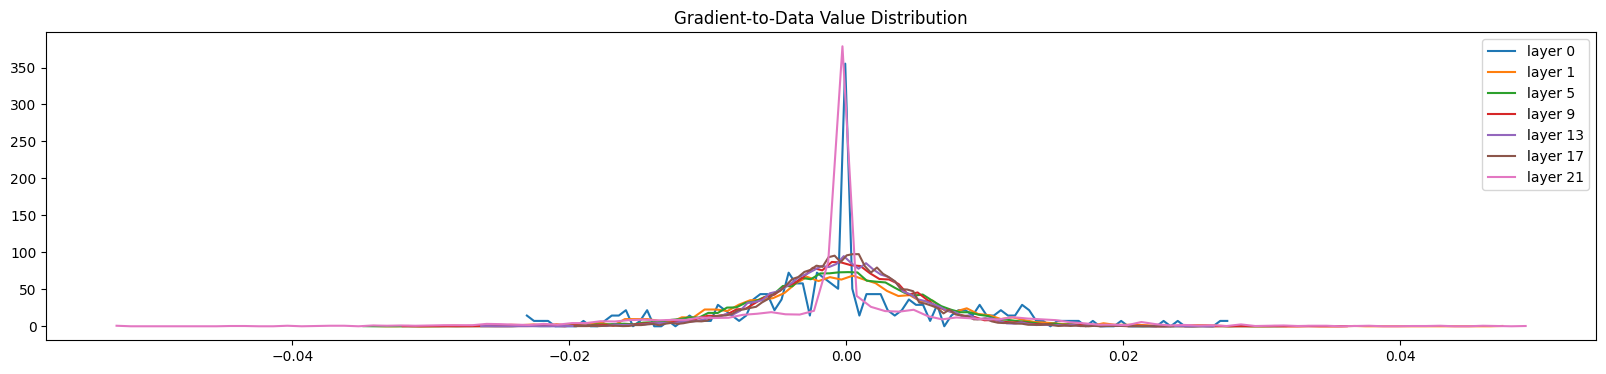

In [84]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    p_grad = p.grad
    if p.ndim == 2:
        print(f"layer {str(i):>2}: weight {str(tuple(p.shape)):>12} | mean {p_grad.mean():+.6f} | std {p_grad.std():.6f} | grad:data {p_grad.std() / p.std():.6f}")
        # Compute histogram
        hy, hx = torch.histogram(p_grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i}')
plt.legend(legends)
plt.title('Gradient-to-Data Value Distribution');

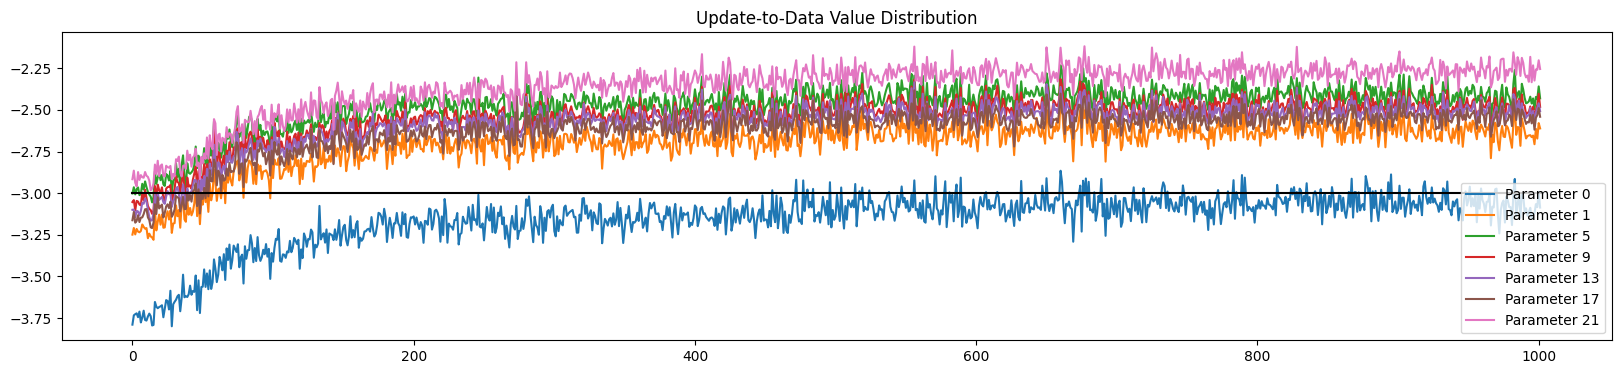

In [85]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    p_grad = p.grad
    if p.ndim == 2:
        plt.plot([update_to_data[j][i] for j in range(len(update_to_data))])
        legends.append(f'Parameter {i}')

# These values should be roughly 1e-3 (i.e. updates to values in tensors are roughly 1/1000th of the values themselves)
# Layer 11 was artificially squashed in initialization, so it makes sense that updates to that matrix are larger
plt.plot([0, len(update_to_data)], [-3, -3], 'k')
plt.legend(legends)
plt.title('Update-to-Data Value Distribution');

In [93]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.012320041656494
val 2.0841143131256104


In [94]:
# Generate names
def generate_names(n, generator=None):
    if generator is None:
        generator = torch.Generator().manual_seed(2147483647 + 10)
    
    for _ in range(n):
        out = []

        context = [0] * BLOCK_SIZE
        while True:
            emb = C[torch.tensor([context])]
            x = emb.view(emb.shape[0], -1)
            for layer in layers:
                x = layer(x)
            probs = F.softmax(x, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=generator).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
        
        print(''.join(i_to_c[i] for i in out))

In [95]:
generate_names(20, torch.Generator().manual_seed(2147483647 + 10))

carlah.
amelle.
khyriri.
reity.
skanya.
eja.
hube.
deliah.
jareei.
nellara.
chaiir.
kaleigh.
ham.
joce.
quintis.
lilah.
jadiquinte.
madiaryn.
kai.
eupitraylen.
